In [17]:
import pandas as pd
import faiss
import numpy as np
import time
import re

from tqdm import tqdm
from module.model.retriever import retriever
from module.model.customFaiss import faiss_engine
from  module.model.gemini import Gemini

file_path = "./data/faq.xlsx"
df = pd.read_excel(file_path, sheet_name="FAQ")
df.reset_index(inplace=True)
gemini = Gemini()

# Augmented FAQ

According to IVF, PQ, and IVF PQ requirements

In [2]:
roles = {
  "Finance_Analyst": "An analytical and detail-oriented individual who specializes in managing budgets, forecasting financial trends, and analyzing data to support the bank's profitability. Adept at handling complex financial models and delivering insights to drive strategic decisions.",
  "Legal_Counsel": "A meticulous and ethical professional with in-depth knowledge of banking laws and regulations. Ensures the bank complies with legal standards while providing advice on contracts, disputes, and regulatory changes.",
  "Branch_Manager": "A goal-oriented leader who oversees the day-to-day operations of a bank branch. Skilled in team management, customer relations, and achieving sales targets while ensuring excellent service delivery.",
  "CEO": "A visionary and charismatic leader responsible for setting the bank's strategic direction, driving growth, and maintaining strong relationships with stakeholders. Combines strategic thinking with a deep understanding of market dynamics.",
  "Loan_Officer": "A personable and empathetic individual who assesses loan applications and assists customers in securing financing. Combines financial knowledge with excellent customer service and decision-making skills.",
  "Personal_Banker": "A client-focused professional who helps individuals manage their financial needs, including deposits, loans, and investments. Excels in building trust, offering tailored solutions, and delivering excellent customer experiences.",
  "Credit_Analyst": "A highly analytical and detail-focused professional who evaluates the creditworthiness of individuals or businesses applying for loans. Demonstrates expertise in financial analysis and risk assessment.",
  "Risk_Manager": "A strategic thinker who identifies, assesses, and mitigates risks that could impact the bank's financial performance or compliance. Combines analytical skills with strong decision-making abilities.",
  "Compliance_Officer": "A principled and organized individual responsible for ensuring the bank adheres to regulatory requirements. Works closely with legal and operational teams to identify risks and implement corrective measures.",
  "Treasury_Manager": "A dynamic and resourceful professional who oversees the bank's liquidity, funding, and financial risk management. Skilled in cash flow analysis, investment decisions, and maintaining relationships with financial institutions."
}

In [3]:
def augment_question(q, role):
    inst = f"You are an employee of Krungthai bank. Your role is {role}, {roles[role]}"
    res = gemini.generate(
        prompt = f"""
        Your task is to paraphrase the given question in Thai language below into the new Thai language question according to your role and style. 
        You will paraphrased a given question into 10 questions, make sure to vary.
        But, remember to keep the main meaning and do not use your prior or any knowledge you have to exaggerate.

        The question: {q}

        Output format: ["paraphrased1", "paraphrased2", ..., "paraphrased10"]
        """,
        system_instruction=inst
    )
    
    return res

In [ ]:
list_of_questions = df.core_question.to_list()
all_paraphrased = {}

for role in roles.keys():
        
    all_paraphrased[role] = []
    
    # Use tqdm to track progress over questions
    for question in tqdm(list_of_questions, desc=f"Processing questions for role: {role}", leave=False, total=len(list_of_questions)):
        while True:
            try:
                # Call the augment_question function
                list_of_paraphrased = augment_question(question, role)
                
                # Append the paraphrased questions to the list for the current role
                all_paraphrased[role].append(list_of_paraphrased)
                
                # Break the while loop if successful
                break
            except Exception as e:
                # Log the error for debugging (optional)
                tqdm.write(f"Error occurred for role '{role}' and question '{question}': {e}")
                
                # Sleep for 10 seconds before retrying
                time.sleep(10)

In [ ]:
all_cleaned = {}
for role in all_paraphrased.keys():
    all_cleaned[role] = [re.findall(r'"([^"]*[\u0E00-\u0E7F]+[^"]*)"', q) for q in all_paraphrased[role]]

In [ ]:
res = pd.DataFrame()

col = list(all_cleaned.keys())

for c in col:
    a = pd.DataFrame(pd.DataFrame(all_cleaned)[c].explode()).reset_index()
    new_a = pd.DataFrame()
    new_a['augmented_question'] = a[c].values
    new_a['augmented_by'] = c
    new_a['index'] = a['index'].values
    res = pd.concat([res, new_a], axis=0, ignore_index=True)

df_final = res.merge(df, on='index')

In [ ]:
df_final.to_csv('./data/augmented_faq.csv', index=False)

# Embed

In [18]:
import os
import json
from tqdm import tqdm
import time

In [19]:
df_final = pd.read_csv('./data/augmented_faq.csv')

In [ ]:
#4815

In [ ]:
all_embeded = []

# Wrapping the iteration with tqdm for a progress bar
for i, q in enumerate(tqdm(df_final.augmented_question.values[4815:], desc="Embedding Questions")):
    while True:  # Keep trying until successful
        try:
            # Attempting to embed the question
            embedding = gemini.embed(q)
            all_embeded.append({q: embedding})

            # Save embedding to a local JSON file
            filename = os.path.join("./data/embeddings", f"embedding_{i}.json")
            with open(filename, "w") as f:
                json.dump({q: embedding}, f)
            
            break  # Exit the while loop on success
        except Exception as e:
            # Handling any exception and retrying
            print(f"Error embedding question at index {i}: {q}. Retrying... Error: {e}")
            time.sleep(1)  # Optional: Add a small delay to avoid overwhelming the system

Embedding Questions:  52%|█████▏    | 2832/5396 [29:14<21:43,  1.97it/s]   

# FAISS

In [3]:
engines = {}
for algo in ["flat_ip", "ivf", "pq", "ivf_pq", "hnsw"]:
    try:
        engines[algo] = retriever(df, faiss_engine(df_final["augmented_question"].to_list(), index_type=algo, nlist=df.main_node.unique(), hnsw_m=8))
    except:
        print(algo, 'has passed')

flat_ip has passed
ivf has passed
pq has passed
ivf_pq has passed
hnsw has passed


In [7]:
r = retriever(df)

In [12]:
e = faiss_engine(df)

FAISS engine built with flat_l2. Total vectors: 102


In [14]:
r = retriever(df, e)

In [15]:
r.retrieve("Hi")

[ResponseCandidate(index=33, distance=0.9616277, core_question='หนังสือเวียนที่เกี่ยวข้อง เพื่อศึกษาเพิ่มเติม', core_answer='น.(ว)(บสส.) 317/2560 ลงวันที่ 28 กุมภาพันธ์ 2560 เรื่อง หลักเกณฑ์การประเมินผลการปฏิบัติงานพนักงานตามสัญญาและการบรรจุเป็นพนักงานประจำของธนาคาร', main_node='performanceAssessment', responsible_team='งานประเมินผลการปฏิบัติงาน, \nฝ่ายบริหารผลการปฏิบัติงานฯ', question_tag='การประเมินผลปฏิบัติงานสำหรับพนักงานเข้าใหม่', question_type='what'),
 ResponseCandidate(index=6, distance=0.97831076, core_question='สอบถามผลสัมภาษณ์', core_answer='กรณีผ่านการสัมภาษณ์ HR จะดำเนินการติดต่อแจ้งผลสัมภาษณ์ไปยังผู้สมัคร หลังจากผ่านความเห็นชอบจากคณะกรรมการพนักงานของหน่วยงานปลายทางที่รับสมัคร ท่านสามารถสอบถามเจ้าหน้าที่ที่ดูแลการรับสมัครตำแหน่งนั้นๆ โดยดูข้อมูลการติดต่อสอบถามได้ที่ประกาศรับสมัคร (Link) หรือเจ้าหน้าที่ที่ติดต่อนัดสัมภาษณ์ได้โดยตรง', main_node='recruitmentRotationAndAppointment', responsible_team='ฝ่ายทรัพยากรบุคคลสัมพันธ์ 1, \nฝ่ายทรัพยากรบุคคลสัมพันธ์ 8', question_tag='in

In [7]:
engines['flat_ip'].retrieve(["ได้เป็นผู้บริหาร ต้องทำยังไงต่อ", "หิวข้าว"])

[ResponseCandidate(index=94, distance=0.7417239, core_question='การปรับโครงสร้างองค์กร และหน้าที่ความรับผิดชอบ มีขั้นตอนการดำเนินการอย่างไร', core_answer='ขั้นตอนการปรับโครงสร้างองค์กร และหน้าที่ความรับผิดชอบ:   1. หน่วยงานจัดทำบันทึกและหน้าที่ความรับผิดชอบใหม่ นำเสนอคณะกรรมการ PMC สายงาน หรือผู้บริหารสายงาน พิจารณาให้ความเห็นชอบ  2. นำส่งบันทึกอนุมัติที่ได้ความเห็นชอบแล้วให้กับฝ่ายทรัพยากรบุคคลสัมพันธ์ 1 - 2 เพื่อประสานงานกับฝ่ายกลยุทธ์ทรัพยากรบุคคลและองค์กร  3. ฝ่ายกลยุทธ์ทรัพยากรบุคคลและองค์กรนำเสนอขออนุมัติการปรับโครงสร้างองค์กรและหน้าที่ความรับผิดชอบตามขอบอำนาจ  4. เมื่อได้รับอนุมัติแล้ว ฝ่ายกลยุทธ์ทรัพยากรบุคคลและองค์กรจะดำเนินการประกาศหนังสือเวียนและคำสั่ง ธ. พร้อมวันที่มีผลบังคับใช้', main_node='OrganizationalInformation', responsible_team='ฝ่ายกลยุทธ์ทรัพยากรบุคคลฯ', question_tag='ขั้นตอนการปรับโครงสร้างองค์กร และหน้าที่ความรับผิดชอบ', question_type=nan),
 ResponseCandidate(index=35, distance=0.7140384, core_question='แบบฟอร์มการประเมินผลหรือหัวข้อการประเมินผล สำหรับพนักงานที่

array([[ 0.00088642,  0.02363747,  0.01960394, ...,  0.01923783,
        -0.03167676,  0.02480354],
       [-0.00225786, -0.00657255,  0.01028185, ...,  0.07226807,
         0.01138341,  0.06531374],
       [-0.00097243,  0.02973945, -0.00080827, ...,  0.01231256,
        -0.03977378,  0.04063863],
       ...,
       [ 0.00213659, -0.02558158, -0.02310469, ...,  0.02031196,
        -0.03198677,  0.02444904],
       [ 0.01828804,  0.02970627,  0.02822982, ...,  0.00591141,
        -0.06911253,  0.06015651],
       [ 0.02320662,  0.00172849,  0.00749617, ...,  0.03459567,
        -0.04150916,  0.02938838]], dtype=float32)

In [6]:
embedding_matrix = np.array(gemini.embed_documents(df["core_question"])).astype('float32')

In [24]:
df.main_node.nunique()

5

In [8]:
quantizer = faiss.IndexFlatL2(embedding_matrix.shape[1])

In [ ]:
faiss.IndexIVFFlat

In [11]:
index = faiss.IndexIVFFlat(quantizer, embedding_matrix.shape[1], 5)

In [12]:
index.train(embedding_matrix)
index.add(embedding_matrix)

WARNING clustering 37 points to 5 centroids: please provide at least 195 training points


In [21]:
d, i = index.search(np.array([gemini.embed("เอกสาร")]).astype('float32'), k = 5)

In [22]:
i

array([[33, 10,  7, 17,  0]])

In [31]:
faiss_retriever.document_storage.metaData

,index,main_node,responsible_team,question_tag,question_type,core_question,core_answer
0,0,recruitmentRotationAndAppointment,"ฝ่ายทรัพยากรบุคคลสัมพันธ์ 1, \nฝ่ายทรัพยากรบุค...","interal_recruitment, status_of_rotation, statu...",how,อยากโอนย้ายหน่วยงานต้องทำอย่างไรบ้าง,ธนาคารมีช่องทางการประกาศรับสมัครพนักงานภายในธน...
1,1,recruitmentRotationAndAppointment,"ฝ่ายทรัพยากรบุคคลสัมพันธ์ 1, \nฝ่ายทรัพยากรบุค...","interal_recruitment, status_of_rotation, statu...",what,มีหน่วยงานหรือตำแหน่งงานไหนที่เปิดรับสมัครบ้าง,ธนาคารมีช่องทางการประกาศรับสมัครพนักงานภายในธน...
2,2,recruitmentRotationAndAppointment,"ฝ่ายทรัพยากรบุคคลสัมพันธ์ 1, \nฝ่ายทรัพยากรบุค...","interal_recruitment, status_of_rotation, statu...",how,แจ้งความประสงค์โอนย้ายผ่านช่องทางของธนาคารแล้ว...,HR จะคัดกรองคุณสมบัติ และส่งให้หน่วยงานพิจารณา...
3,3,recruitmentRotationAndAppointment,"ฝ่ายทรัพยากรบุคคลสัมพันธ์ 1, \nฝ่ายทรัพยากรบุค...","interal_recruitment, status_of_rotation, statu...",why,คีย์สมัครเข้ามาทางช่องทางที่ประกาศรับสมัครแล้ว...,HR จะคัดกรองคุณสมบัติ และส่งให้หน่วยงานพิจารณา...
4,4,recruitmentRotationAndAppointment,"ฝ่ายทรัพยากรบุคคลสัมพันธ์ 1, \nฝ่ายทรัพยากรบุค...","interal_recruitment, status_of_rotation, statu...",what,สอบถามกระบวนการในการโอนย้ายหน่วยงานภายในธนาคาร,HR จะคัดกรองคุณสมบัติ และส่งให้หน่วยงานพิจารณา...
5,5,recruitmentRotationAndAppointment,"ฝ่ายทรัพยากรบุคคลสัมพันธ์ 1, \nฝ่ายทรัพยากรบุค...","interal_recruitment, status_of_rotation, statu...",why,เข้าสู่กระบวนการสัมภาษณ์แล้ว แต่ยังไม่ได้รับกา...,กรณีผ่านการสัมภาษณ์ HR จะดำเนินการติดต่อแจ้งผล...
6,6,recruitmentRotationAndAppointment,"ฝ่ายทรัพยากรบุคคลสัมพันธ์ 1, \nฝ่ายทรัพยากรบุค...","interal_recruitment, status_of_rotation, statu...",what,สอบถามผลสัมภาษณ์,กรณีผ่านการสัมภาษณ์ HR จะดำเนินการติดต่อแจ้งผล...
7,7,recruitmentRotationAndAppointment,"ฝ่ายทรัพยากรบุคคลสัมพันธ์ 1, \nฝ่ายทรัพยากรบุค...","interal_recruitment, status_of_rotation, statu...",what,สอบถามเกณฑ์การโอนย้ายของธนาคาร,หลักเกณฑ์การโอนย้ายของพนักงาน ขึ้นกับ 3 กรณี: ...
8,8,recruitmentRotationAndAppointment,"ฝ่ายทรัพยากรบุคคลสัมพันธ์ 1, \nฝ่ายทรัพยากรบุค...","interal_recruitment, status_of_rotation, statu...",what,ต้องมีอายุงานในสังกัดปัจจุบันเท่าไหร่จึงจะโอนย...,หลักเกณฑ์การโอนย้ายของพนักงาน ขึ้นกับ 3 กรณี: ...
9,9,recruitmentRotationAndAppointment,"ฝ่ายทรัพยากรบุคคลสัมพันธ์ 1, \nฝ่ายทรัพยากรบุค...","interal_recruitment, status_of_rotation, statu...",when,ผ่านสัมภาษณ์แล้วจะได้โอนย้ายเมื่อไหร่,โปรดตรวจสอบสถานะการโอนย้ายกับเจ้าหน้าที่ที่ดูแ...


In [32]:
faiss_retriever.retrieve("ต้นสังกัดมีสิทธิ์ไม่ปล่อยตัวพนักงานหรือไม่")

[ResponseCandidate(index=2, main_node='recruitmentRotationAndAppointment', responsible_team='ฝ่ายทรัพยากรบุคคลสัมพันธ์ 1, \nฝ่ายทรัพยากรบุคคลสัมพันธ์ 4', question_tag='interal_recruitment, status_of_rotation, status_of_appointment, criteria_and_process_of_rotation_between_bu', question_type='how', core_question='แจ้งความประสงค์โอนย้ายผ่านช่องทางของธนาคารแล้ว ขั้นตอนต่อไปต้องทำอย่างไร', core_answer='HR จะคัดกรองคุณสมบัติ และส่งให้หน่วยงานพิจารณา หากท่านได้รับการคัดเลือก จะมีเจ้าหน้าที่ติดต่อไปยังท่าน ทั้งนี้ ท่านสามารถสอบถามเจ้าหน้าที่ที่ดูแลการรับสมัครตำแหน่งนั้นๆ โดยดูข้อมูลการติดต่อสอบถามได้ที่ประกาศรับสมัคร (Link)'),
 ResponseCandidate(index=5, main_node='recruitmentRotationAndAppointment', responsible_team='ฝ่ายทรัพยากรบุคคลสัมพันธ์ 1, \nฝ่ายทรัพยากรบุคคลสัมพันธ์ 7', question_tag='interal_recruitment, status_of_rotation, status_of_appointment, criteria_and_process_of_rotation_between_bu', question_type='why', core_question='เข้าสู่กระบวนการสัมภาษณ์แล้ว แต่ยังไม่ได้รับการติดต่อจาก H

In [24]:
faiss_engine.retrieve("สัมภาษณ์", k=5)

array([5, 4, 6, 0, 3])

# Self-RAG

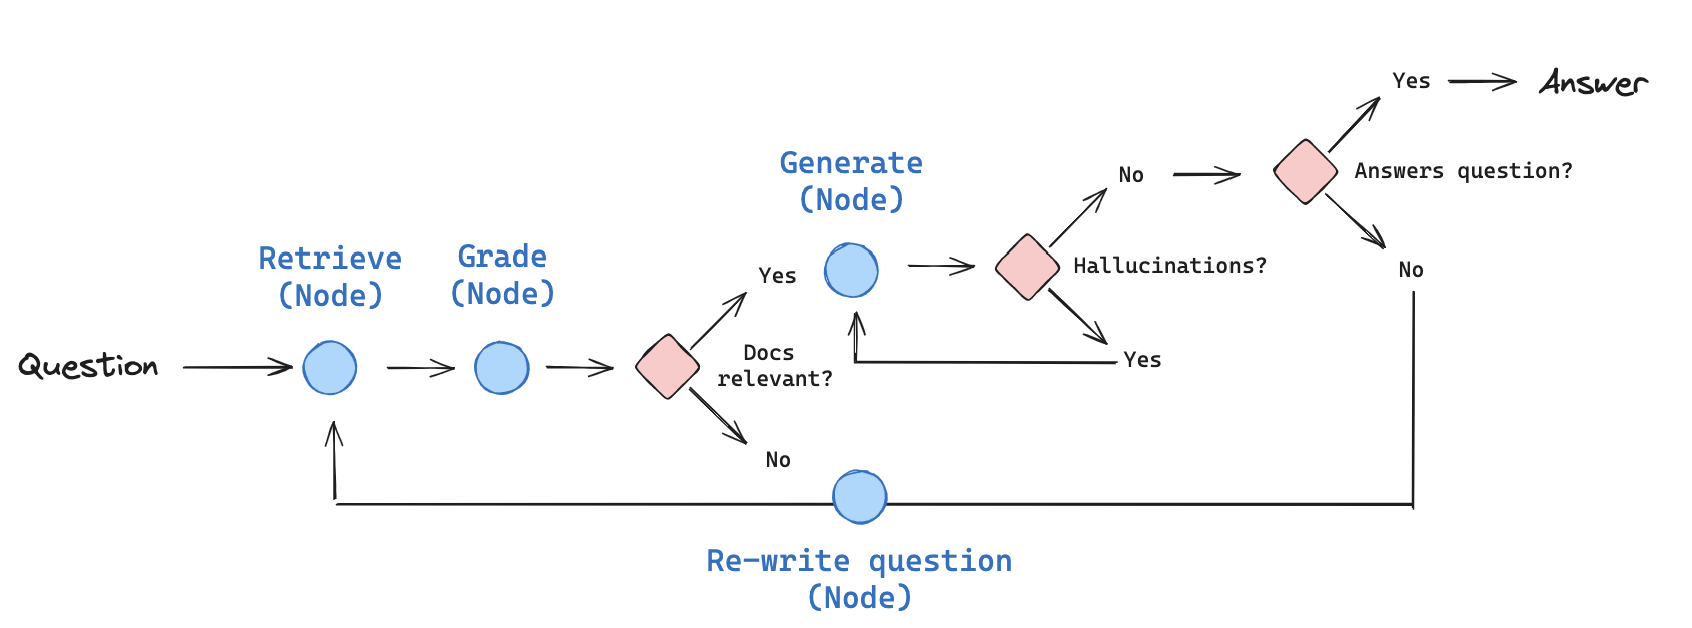

In [20]:
from module.model.gemini import Gemini
from typing_extensions import TypedDict

In [19]:
hashed_passwords.hash_passwords(passwords)

TypeError: list indices must be integers or slices, not str

In [2]:
from IPython.display import Markdown, display

def print_md(md_text):
    display(Markdown(md_text))

from module.agent import helpdeskAgent

agent = helpdeskAgent(faiss_retriever)

In [3]:
agent.response("สัมภาษณ์งานผ่านต้องทำยังไงต่อ")

AI is thinking...
AI is retrieving relevant information...


'หลังจากสัมภาษณ์งานผ่านแล้ว ทางฝ่ายบุคคลจะคัดกรองคุณสมบัติและส่งให้หน่วยงานพิจารณาค่ะ หากท่านได้รับการคัดเลือก จะมีเจ้าหน้าที่ติดต่อไปยังท่าน  ท่านสามารถสอบถามเจ้าหน้าที่ที่ดูแลการรับสมัครตำแหน่งนั้นๆ โดยดูข้อมูลการติดต่อสอบถามได้ที่ประกาศรับสมัคร (Link) นะคะ \n'

In [10]:
agent.response("โลกมีดวงจันทร์กี่ดวง")

AI is thinking...


'ขออภัยค่ะ ฉันไม่เข้าใจคำถาม  คุณต้องการสอบถามเกี่ยวกับอะไร? '

In [12]:
print(agent.get_system_instruction())


        You are a female helpful HR helpdesk assistant for Krungthai Bank. 
        Your role is to form an answer that you'll be given and reply back in Thai.
        Without prying and asking for private information.
        
            Prvoding with the conversation history:
            
        The following is the memory of the HelpdeskAgent containing previous interactions and context. 
        Use this information to generate accurate and contextually appropriate responses.
        
Employee: สัมภาษณ์งานผ่านต้องทำยังไงต่อ
AI: หลังจากสัมภาษณ์งานผ่านแล้ว ทางฝ่ายบุคคลจะคัดกรองคุณสมบัติและส่งให้หน่วยงานพิจารณาค่ะ หากท่านได้รับการคัดเลือก จะมีเจ้าหน้าที่ติดต่อไปยังท่าน  ท่านสามารถสอบถามเจ้าหน้าที่ที่ดูแลการรับสมัครตำแหน่งนั้นๆ โดยดูข้อมูลการติดต่อสอบถามได้ที่ประกาศรับสมัคร (Link) นะคะ 

Employee: ชื่อไรจ๊ะน้องสาว
AI: ขออภัยค่ะ ฉันเป็นระบบ AI ที่ได้รับการออกแบบมาเพื่อช่วยเหลือพนักงานของธนาคารกรุงไทย  ฉันไม่มีชื่อและไม่สามารถให้ข้อมูลส่วนตัวได้  คุณมีข้อสงสัยเกี่ยวกับการสมัครงานหรือไ

In [4]:
import pandas as pd

df = pd.read_excel("/Users/sirabhobs/Downloads/HR Helpdesk_Q&A Chatbot.xlsx", sheet_name="FAQ")
df.reset_index(inplace=True)

In [2]:
from module.model.retriever import retriever
from module.model.retriever import faiss_engine

In [5]:
r = retriever(df)

In [7]:
from module.agent import helpdeskAgent

In [8]:
agent = helpdeskAgent(r)

In [9]:
agent.response("อยากลาออก")

'สวัสดีค่ะ 😊  \n\nเข้าใจค่ะ  ถ้าคุณต้องการลาออกจากงาน คุณสามารถแจ้งความประสงค์ต่อหัวหน้างานของคุณได้โดยตรง  \n\nหัวหน้างานของคุณจะช่วยคุณในการดำเนินการตามขั้นตอนการลาออก  \n\nอย่าลืมตรวจสอบเงื่อนไขการลาออกในสัญญาจ้างงานของคุณด้วยนะคะ  \n\nหากมีข้อสงสัยเพิ่มเติม  คุณสามารถติดต่อฝ่ายทรัพยากรบุคคลได้ที่เบอร์โทรศัพท์  [เบอร์โทรศัพท์ฝ่ายทรัพยากรบุคคล]  \n\nขอให้คุณโชคดีกับการตัดสินใจของคุณค่ะ  \n'

In [7]:
@dataclass
class DocumentStore:
    metaData: Dict[str, Any]
    retrieverEngine: Any

In [53]:

@dataclass
class ResponseCandidate:
    index: int
    main_node: str
    responsible_team: str
    question_tag: str
    question_type: str
    core_question: str
    core_answer: str

    def to_dict(self):
        """Export the dataclass to a dictionary."""
        return asdict(self)

    def to_list(self):
        """Export the dataclass to a list of values."""
        return list(asdict(self).values())

In [40]:
class faiss_engine():
    
    def __init__(self, document):
        self.embedder = Gemini()
        self.engine = self.build(document)
        
    def __embed_document(self, document):
        return np.array(self.embedder.embed_documents(document)).astype('float32')
        
    def build(self, document):
        
        embedding_matrix = self.__embed_document(document)
        retriver_engine = faiss.IndexFlatL2(embedding_matrix.shape[1])
        retriver_engine.add(embedding_matrix)
        
        return retriver_engine
    
    def retrieve(self, question, k):
        
        emb_question = self.embedder.embed(question)
        emb_question = np.array([emb_question], dtype='float32')  #query
        result = self.engine.search(emb_question, k)
        
        return result[1][0]

In [93]:
class retriever():
    def __init__(self, document:pd.DataFrame, method = faiss_engine):
        """Retriever instance

        Args:
            document (pd.DataFrame): Whole document
            method (str): Defaults to 'faiss'
        """
        self.engine = method(document)
        self.document_storage = DocumentStore(metaData=document, retrieverEngine=self.engine.build(document))
        
    def get_content(self, query_index: int) -> ResponseCandidate:
        
        row = df[df['index'] == query_index]
        
        if row.empty:
            raise ValueError(f"No row found with index {query_index}")
        
        return ResponseCandidate(**row.iloc[0].to_dict())
        
    def retrieve(self, question, k=3):
        
        result = self.engine.retrieve(question, k)
        
        return [self.get_content(res) for res in result]

In [54]:
r = retriever(df)

In [55]:
res = r.retrieve("สัมภาษณ์ดูผลที่ไหน")

In [57]:
res[0].to_dict()

{'index': 4,
 'main_node': 'recruitmentRotationAndAppointment',
 'responsible_team': 'ฝ่ายทรัพยากรบุคคลสัมพันธ์ 1, \nฝ่ายทรัพยากรบุคคลสัมพันธ์ 6',
 'question_tag': 'interal_recruitment, status_of_rotation, status_of_appointment, criteria_and_process_of_rotation_between_bu',
 'question_type': 'what',
 'core_question': 'สอบถามกระบวนการในการโอนย้ายหน่วยงานภายในธนาคาร',
 'core_answer': 'HR จะคัดกรองคุณสมบัติ และส่งให้หน่วยงานพิจารณา หากท่านได้รับการคัดเลือก จะมีเจ้าหน้าที่ติดต่อไปยังท่าน ทั้งนี้ ท่านสามารถสอบถามเจ้าหน้าที่ที่ดูแลการรับสมัครตำแหน่งนั้นๆ โดยดูข้อมูลการติดต่อสอบถามได้ที่ประกาศรับสมัคร (Link)'}

In [94]:
class helpdeskAgent():
    def __init__(self, retriever):
        self.retriver_engine = retriever
        self.agent = Gemini()
        
    def retrieve(self, question):
        return self.retriver_engine.retrieve(question)
            
    def response(self, question):
        
        candidates = self.retrieve(question)
        prompt = f"""
    
        Given
        •	Dialogue Answer 1: {candidates[0].to_dict()["core_answer"]}
        •	Dialogue Answer 2: {candidates[1].to_dict()["core_answer"]}
        •	Dialogue Answer 3: {candidates[2].to_dict()["core_answer"]}
        
        {question}?
        
        """
        return self.agent.generate(prompt)

In [63]:
r = retriever(df)

In [95]:
agent = helpdeskAgent(r)

In [97]:
agent.response("สัมภาษณ์ดูผลที่ไหน")

'สวัสดีค่ะ 😊\n\nหลังจากสัมภาษณ์เสร็จแล้ว คุณสามารถติดตามผลได้จากช่องทางต่อไปนี้ค่ะ:\n\n* **ติดต่อเจ้าหน้าที่ที่ดูแลการรับสมัครตำแหน่งนั้นๆ:** คุณสามารถดูข้อมูลการติดต่อสอบถามได้ที่ประกาศรับสมัคร (Link) หรือเจ้าหน้าที่ที่ติดต่อนัดสัมภาษณ์ได้โดยตรง\n* **รอการติดต่อจาก HR:** หากคุณผ่านการสัมภาษณ์ HR จะดำเนินการติดต่อแจ้งผลสัมภาษณ์ไปยังผู้สมัคร หลังจากผ่านความเห็นชอบจากคณะกรรมการพนักงานของหน่วยงานปลายทางที่รับสมัคร\n\nหากมีข้อสงสัยเพิ่มเติม สามารถสอบถามได้ตลอดเวลานะคะ 😊\n'